<a href="https://colab.research.google.com/github/jcandane/CellList/blob/main/celllistboxbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jcandane/CellList
!git clone https://github.com/jcandane/xyz_file_manager

fatal: destination path 'CellList' already exists and is not an empty directory.
fatal: destination path 'xyz_file_manager' already exists and is not an empty directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from CellList.CellList import Cell_List
from xyz_file_manager.xyz_manager import xyz_reader

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

def get_router(l):
    router  = np.triu( np.arange(0,l,1)[None,:] + np.cumsum( np.roll(np.flip(np.arange(0,l,1)), 1))[:,None] )
    router -= (np.eye(l, dtype=np.int64) - 1) * router.T
    return router


def celllist(R_ix, cube_size, boxboxcuttoff=1.5):
    """
    GIVEN:  R_ix (Cartesian Positions)
            cube_size (Cell List Box size)
            **boxboxcuttoff (cutoff for Box Verlet List in units of `cube_size`)
    GET:    IJ (Box Pair-Neighbors)
            ind (indices of atoms sorted by which boxes they belong to)
            sor (sorted array, how to slice the indice array to get members of a box)
    """

    R_ix_int  = ( R_ix/cube_size ).astype(int)
    lims      = 1 + np.amax( R_ix_int, axis=0 ) - np.amin( R_ix_int, axis=0 )
    boxes     = np.arange(0, np.prod(lims), 1, dtype=int).reshape((lims[0],lims[1],lims[2]))

    ### get indices of 
    box = boxes[R_ix_int[:,0], R_ix_int[:,1], R_ix_int[:,2]] ## get box for each atom
    ind = np.argsort(box) ## find indices beloning to a box
    sor = np.append([0], np.where( np.diff( box[ind] ) >= 1 )[0] ) ### find where boxes end, i.e. box[ind] = np.sort( box ) !!! >=   ### if this is greater than 1 (not equal to get rid of box??)
    sor = np.append(sor, len(box)) ## !!

    ### get Box center coordinates
    x_  = np.arange(0, lims[0], 1, dtype=int)
    y_  = np.arange(0, lims[1], 1, dtype=int)
    z_  = np.arange(0, lims[2], 1, dtype=int)
    xyz = np.array(np.meshgrid(x_, y_, z_))

    ### Box Verlet List
    R_Bx  = (xyz.swapaxes(0,3)).reshape((xyz.size//xyz.shape[0] , xyz.shape[0]), order="F")
    Boxdistances = np.linalg.norm( R_Bx[None, :,:] -  R_Bx[:,None,:] , axis=2)
    IJ = np.asarray( np.where( np.logical_and( Boxdistances >= 0, Boxdistances < 1.5) ) ).T

    return IJ, ind, sor



In [3]:
Z, R_ix = xyz_reader("Ar_1000.xyz") ## R_ix [Å]

IJ, indexes, sorted = celllist(R_ix, 55) ## box-size in [Å]

print("Number of Boxes: " + str(sorted.shape[0] - 1))
print("Number of Box-Box Interactions: " + str(IJ.size//2) )

Number of Boxes: 1
Number of Box-Box Interactions: 1


In [4]:
Z, R_ix = xyz_reader("Ar_1000.xyz") ## R_ix [Å]

IJ, indexes, sorted = celllist(R_ix, 55) ## box-size in [Å]

print("Number of Boxes: " + str(sorted.shape[0]))
print("Number of Box-Box Interactions: " + str(IJ.shape[0]) )

print( len(R_ix) )
print( len(indexes) )
#IJ
print(sorted)


print("==========")
R_ix_int  = ( R_ix/1000 ).astype(int)
lims      = 1 + np.amax( R_ix_int, axis=0 ) - np.amin( R_ix_int, axis=0 )
boxes     = np.arange(0, np.prod(lims), 1, dtype=int).reshape((lims[0],lims[1],lims[2]))

print( boxes.size )

box = boxes[R_ix_int[:,0], R_ix_int[:,1], R_ix_int[:,2]] ## get box for each atom

print( np.allclose( box, np.zeros(len(R_ix), dtype=np.int64) ) ) ## all atoms belong to this box

ind = np.argsort(box) ## find indices beloning to a box
sor = np.append([0], np.where( np.diff( box[ind] ) >= 1 )[0] )
print( sor ) 

### I_i   = indexes[ sorted[I]:sorted[I+1] ] gets members-in-a-box location
sor = np.append(sor, len(box))
print(sor)


### get Box center coordinates
x_  = np.arange(0, lims[0], 1, dtype=int)
y_  = np.arange(0, lims[1], 1, dtype=int)
z_  = np.arange(0, lims[2], 1, dtype=int)
xyz = np.array(np.meshgrid(x_, y_, z_))

### Box Verlet List
R_Bx  = (xyz.swapaxes(0,3)).reshape((xyz.size//xyz.shape[0] , xyz.shape[0]), order="F")
print( R_Bx )
Boxdistances = np.linalg.norm( R_Bx[None,:,:] -  R_Bx[:,None,:] , axis=2)
print( Boxdistances )

II, JJ = np.where( np.logical_and(( Boxdistances ) >= 0, ( Boxdistances ) < 1.5) )
IJ = np.asarray([II, JJ]).T
IJ.size/2

Number of Boxes: 2
Number of Box-Box Interactions: 1
4631
4631
[   0 4631]
1
True
[0]
[   0 4631]
[[0 0 0]]
[[0.]]


1.0

## Tabulated Potential

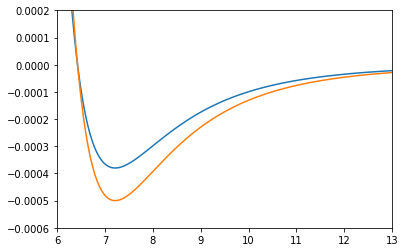

-206.3605800791076


In [5]:
#### !!! We have to deal with 3 spatial units: Å (Ångström), a0 (Bohr), & u (tabulated units) !!!
## https://simonensemble.github.io/PorousMaterials.jl/dev/force_field/


åCu = 100      # å/u  ##
åCÅ = 1.889727  # å/Å
ÅCu = åCu / åCÅ # Å/u


## http://www.sklogwiki.org/SklogWiki/index.php/Argon
σ = 6.42507 ## å, in bohr xor 0.34 nm [Rahman 1964] 
#ε = 3.80e-4  ## 120 K  [Rahman 1964]
ε = np.array([3.80e-4, 5.00e-4, 3.00e-4]) ## np.linspace(1e-6, 1e-4, 100)

Z_consdier = np.array(["Ar", "Ar*"]) ## ordered by unary index, e.g. 0->"Ar", 1->"Ar*"
u      = 0.01 ## å
R_in   = 2.0
R_out  = 180.0

### get pair-types
router = get_router(len(Z_consdier))

### domain in tabulated units
xi     = np.arange( 0.0,  R_in, u)
x      = np.arange(R_in, R_out, u) ### these are in Å, units, R_ix / u
xx     = np.concatenate((xi, x))

### calculate potential in tabulated units
LJE_Ar  =  4*np.einsum("a, x -> ax", ε, ((σ/x)**12 - (σ/x)**6))
LJf_Ar  = 24*np.einsum("a, x -> ax", ε, (σ**6)*(2*σ**6/(x**13) - 1/(x**7)))
LJE_Ari = np.zeros( (LJE_Ar.shape[0], xi.shape[0]) ) ## 0-part close to atomic-core
LJf_Ari = np.zeros( (LJf_Ar.shape[0], xi.shape[0]) ) ## 0-part close to atomic-core

### package+up
LJE_Ar = np.concatenate((LJE_Ari, LJE_Ar), axis=1)
LJf_Ar = np.concatenate((LJf_Ari, LJf_Ar), axis=1)
E_nAR = np.asarray([LJE_Ar, LJf_Ar])






def LJ_tabulated(A, u=0.001):

    np.unique(A)
    pairtype = None

    return E_nAR, u, pairtype

np.unique(Z)


import matplotlib.pyplot as plt

plt.plot(xx,E_nAR[0,0])
plt.plot(xx,E_nAR[0,1])
plt.xlim([6,13])
plt.ylim([-0.0006,0.0002])
plt.show()

print(E_nAR[0,1,1500]*(4100)**2)

## Box-Box Interaction

In [6]:
def calcBOXBOX(C_ix, AT_i,    IJ, indexes, sorted,     E_nAR, u, router):
    """
    GIVEN:  Atom Character;   R_ix (positions), AT_i (Unary Atom-Types)
            Box Neighborhood; IJ (Box Pairs), indexes (over all atoms), sorted (over all boxes)
            Potential;  E_nAR (Potential; n (derivative), A (pair-type), and R (Radial distance))
                        u (unit of potential vs Bohr)
                        router (router for pair-wise atom types)
    GET:    E (energy), f_ix (force), and g_r (pair-correlation)
    """

    R_ix  = C_ix * åCu #/u ## convert R_ix into tabulated units
    E     = 0.
    f_ix  = np.zeros(R_ix.shape)
    g_r   = np.zeros(E_nAR[0].shape)
    for i in range(len(IJ)):
        I, J  = IJ[i]
        I_i   = indexes[ sorted[I]:sorted[I+1] ] ## atom indices belonging to box I
        J_j   = indexes[ sorted[J]:sorted[J+1] ] ## atom indices belonging to box J

        ## displacement/distance calculation
        R_ijx    = R_ix[ I_i, None, : ] - R_ix[ None, J_j, : ]
        distance = np.linalg.norm(R_ijx, axis=2)
        R_ijx   *= 1/(distance[:,:,None] + 1e-10)
        N, dx    = distance.astype(int), distance-distance.astype(int)

        ## get pair-atom-types from unary-atom-types
        AT = router[ np.outer(AT_i[I_i], np.ones(len(J_j), dtype=int)) , np.outer(np.ones(len(I_i), dtype=int), AT_i[J_j]) ]

        ## save pair-correlation, pair-energy, & pair-forces
        g_r[AT, N] += 1
        E          += np.sum( E_nAR[ 0, AT, N ] - (E_nAR[ 1, AT, N ]/åCu) * dx )/2 ### use instead analytic derivative?? E_nAR[ 1, AT, N ]??
        #E          += np.sum(E_nAR[ 0, AT, N ] + (E_nAR[ 0, AT, N+1 ] - E_nAR[ 0, AT, N ] ) * dx)/2 ### use instead analytic derivative?? E_nAR[ 1, AT, N ]??
        f_ijx       =  (E_nAR[ 1, AT, N ] + (E_nAR[ 1, AT, N+1 ] - E_nAR[ 1, AT, N ] ) * dx)[:,:,None] * R_ijx
        f_ix[I_i]  += np.sum( f_ijx, axis=1)
        f_ix[J_j]  -= np.sum( f_ijx, axis=0)

    return E, f_ix, g_r 

start = time.time()

AT_i = np.zeros(Z.shape, dtype=int)

E, f_ix, g_r = calcBOXBOX(R_ix * åCÅ, AT_i,    IJ, indexes, sorted,     E_nAR, u, router)

print("Energy    = %4.12f a.u." %E)
print("net force = %4.12f a.u." %(np.sum(f_ix)))
print("timer     = %4.6f s" % (time.time()-start))

Energy    = -13.306379178171 a.u.
net force = 0.000000000000 a.u.
timer     = 7.577342 s


### Actual Energy

In [7]:
#np.sum( E_nAR[ 0, 0, np.linalg.norm( R_ix[ :, None, : ]/u - R_ix[ None, :, : ]/u , axis=2).astype(np.int64)] )/2
#np.triu(np.linalg.norm( R_ix[ :, None, : ] - R_ix[ None, :, : ], axis=2), 1)
#### so R_ix is in Å

x = np.linalg.norm( R_ix[ :, None, : ] - R_ix[ None, :, : ] , axis=2) * åCÅ ## Å --> å 
x = x[np.triu_indices(len(x), k = 1)]
print("Min Distance Seperation:   %4.8f Bohr" % (np.amin(x)))
print("Max Distance Seperation: %4.8f Bohr" % (np.amax(x)))

E_tot = np.sum( 4*ε[0]*((σ/x)**12 - (σ/x)**6) )
print("Full Pair-Wise Energy  : %4.8f a.u." %E_tot )

x *= åCu ## get x in correct units...
N, dx = x.astype(int), x-x.astype(int)
print(np.sum( E_nAR[ 0, 0, N ] ) - E_tot)
print(np.sum( E_nAR[ 0, 0, N ] + (E_nAR[ 0, 0, N+1 ] - E_nAR[ 0, 0, N ] ) * dx ) - E_tot)
print(np.sum( E_nAR[ 0, 0, N ] + (-E_nAR[ 1, 0, N ]/åCu ) * dx ) - E_tot)

print("Energy Difference (E_celllist-E_tot) : %4.12f a.u." %(E - E_tot))
print("This energy difference matching the interpolation above!!")

Min Distance Seperation:   7.02327101 Bohr
Max Distance Seperation: 172.03430295 Bohr
Full Pair-Wise Energy  : -13.30626627 a.u.
0.0037495261734630247
0.00023625213077416163
-0.00011290696113164245
Energy Difference (E_celllist-E_tot) : -0.000112906961 a.u.
This energy difference matching the interpolation above!!


In [8]:
print(E_nAR[ 0, 0, 1500+1 ] - E_nAR[ 0, 0, 1500 ] )
E_nAR[ 1, 0, 1500 ] / åCu ## get in units

3.7001841951257e-08


-3.7087302002713626e-08

# Dynamics ?

In [9]:
Element_Names = { 'e':0,  0:'e' ,   'H':  1,  1:'H' ,  'He':  2,  2:'He',
               'Li':  3,  3:'Li',  'Be':  4,  4:'Be',   'B':  5,  5:'B' ,   'C':  6,  6:'C' ,   'N':  7,  7:'N' ,   'O':  8,  8:'O' ,   'F':  9,  9:'F' ,  'Ne': 10, 10:'Ne', 
               'Na': 11, 11:'Na',  'Mg': 12, 12:'Mg',  'Al': 13, 13:'Al',  'Si': 14, 14:'Si',   'P': 15, 15:'P' ,   'S': 16, 16:'S' ,  'Cl': 17, 17:'Cl',  'Ar': 18, 18:'Ar',
                'K': 19, 19:'K' ,  'Ca': 20, 20:'Ca',  'Sc': 21, 21:'Sc',  'Ti': 22, 22:'Ti',   'V': 23, 23:'V' ,  'Cr': 24, 24:'Cr',  'Mn': 25, 25:'Mn',  'Fe': 26, 26:'Fe',  'Co': 27, 27:'Co',  'Ni': 28, 28:'Ni',  'Cu': 29, 29:'Cu',  'Zn': 30, 30:'Zn',  'Ga': 31, 31:'Ga',  'Ge': 32, 32:'Ge',  'As': 33, 33:'As',  'Se': 34, 34:'Se',  'Br': 35, 35:'Br',  'Kr': 36, 36:'Kr', 
               'Rb': 37, 37:'Rb',  'Sr': 38, 38:'Sr',   'Y': 39, 39:'Y' ,  'Zr': 40, 40:'Zr',  'Nb': 41, 41:'Nb',  'Mo': 42, 42:'Mo',  'Tc': 43, 43:'Tc',  'Ru': 44, 44:'Ru',  'Rh': 45, 45:'Rh',  'Pd': 46, 46:'Pd',  'Ag': 47, 47:'Ag',  'Cd': 48, 48:'Cd',  'In': 49, 49:'In',  'Sn': 50, 50:'Sn',  'Sb': 51, 51:'Sb',  'Te': 52, 52:'Te',   'I': 53, 53:'I' ,  'Xe': 54, 54:'Xe',
               'Cs': 55, 55:'Cs',  'Ba': 56, 56:'Ba',  'La': 57, 57:'La',  'Ce': 58, 58:'Ce',  'Pr': 59, 59:'Pr',  'Nd': 60, 60:'Nd',  'Pm': 61, 61:'Pm',  'Sm': 62, 62:'Sm',  'Eu': 63, 63:'Eu',  'Gd': 64, 64:'Gd',  'Tb': 65, 65:'Tb',  'Dy': 66, 66:'Dy',  'Ho': 67, 67:'Ho',  'Er': 68, 68:'Er',  'Tm': 69, 69:'Tm',  'Yb': 70, 70:'Yb',  'Lu': 71, 71:'Lu',  'Hf': 72, 72:'Hf',  'Ta': 73, 73:'Ta',   'W': 74, 74:'W' ,  'Re': 75, 75:'Re',  'Os': 76, 76:'Os',  'Ir': 77, 77:'Ir',  'Pt': 78, 78:'Pt',  'Au': 79, 79:'Au', 'Hg': 80, 80:'Hg',  'Tl': 81, 81:'Tl',  'Pb': 82, 82:'Pb',  'Bi': 83, 83:'Bi',  'Po': 84, 84:'Po', 'At': 85, 85:'At', 'Rn': 86, 86:'Rn', 
               'Fr': 87, 87:'Fr',  'Ra': 88, 88:'Ra',  'Ac': 89, 89:'Ac',  'Th': 90, 90:'Th',  'Pa': 91, 91:'Pa',   'U': 92, 92:'U' ,  'Np': 93, 93:'Np',  'Pu': 94, 94:'Pu',  'Am': 95, 95:'Am',  'Cm': 96, 96:'Cm',  'Bk': 97, 97:'Bk',  'Cf': 98, 98:'Cf',  'Es': 99, 99:'Es',  'Fm':100,100:'Fm',  'Md':101,101:'Md',  'No':102,102:'No',  'Lr':103,103:'Lr',  'Rf':104,104:'Rf',  'Db':105,105:'Db',  'Sg':106,106:'Sg',  'Bh':107,107:'Bh',  'Hs':108,108:'Hs',  'Mt':109,109:'Mt',  'Ds':110,110:'Ds',  'Rg':111,111:'Rg', 'Cn':112,112:'Cn',  'Nh':113,113:'Nh',  'Fl':114,114:'Fl',  'Mc':115,115:'Mc',  'Lv':116,116:'Lv', 'Ts':117,117:'Ts', 'Og':118,118:'Og'}

nums = np.arange(1,119,1, dtype=int)

for i in range(len(nums)):
    #print(Element_Names[i] + "\t")
    None

In [11]:
f = "SCHWERDTFEGER2018.txt"
fp = open(f, 'r')

lines = fp.readlines()
asd = []
qwe = []
for i in lines: #range(len(lines)):
    if (i)[0] != "[":
        if len(i.split()) > 2:
            if i.split()[3] == "recommended":
                qwe.append(i)
            else:
                asd.append(i.split()[1])
        else:
            continue

len(asd)

127